In [1]:
from numpy import random as rd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")
from tqdm import tqdm
from metodos.MSC import vcMSC, ordMSC
from metodos.CSM import vcCSM, ordCSM
from metodos.geraSenoide import geraSenoide
from metodos.getFreq import getFreq

Bin 1000
Frequência: 100.0 = 100 (f0 do sinal original)
Logo, para selecionar o valor da fft na f0, por exemplo:
S[np.where(F==f0)[0][0]] => 4.999999999999998 = S[bin] = S[500] =  4.302438888628108e-15


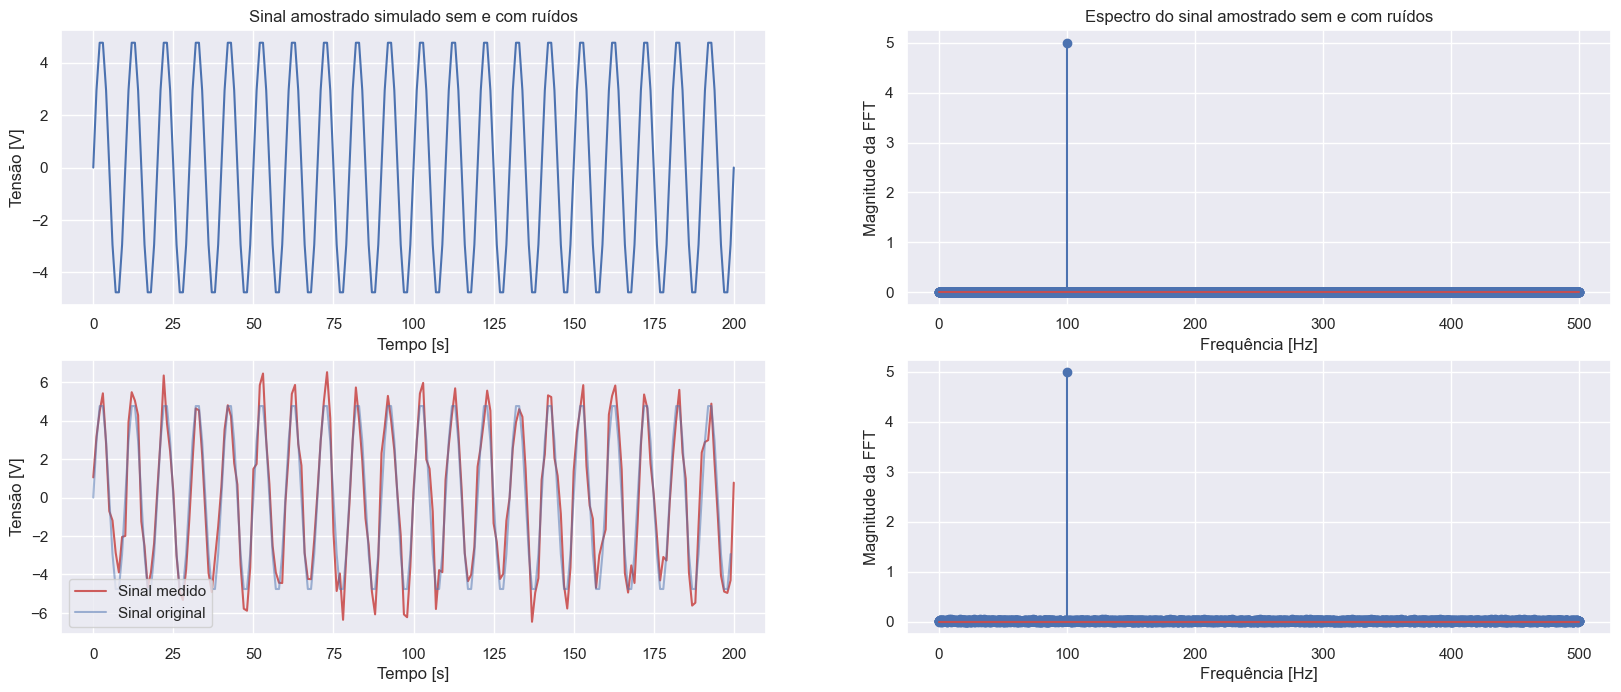

In [11]:
# Mostrando primeiros 20 segundos:
f0 = 100
fs = 1000
M = 10
tj = fs
N = M*tj
t = np.linspace(0,N-1,num=N)

ruido1 = rd.randn(N)
ruido2 = 5*rd.randn(N)+10
sinal = geraSenoide(amplitude=5, N=N, f0 = f0, fs=fs)
[F, S, _] = getFreq(sinal = sinal, fs=fs)
bin_f0 = np.where(F==f0)[0][0]

# Senoide 
plt.subplot(221);
sns.lineplot(y = sinal[0:round(20*N/(fs))+1], x = t[0:round(20*N/(fs))+1]);
# (2 ciclos = 20 seg => 10 seg / ciclo => fl = 1/10 = 0.1 Hz, frequencia normalizada f/fs, correta!)
plt.ylabel('Tensão [V]');
plt.xlabel('Tempo [s]');
plt.title('Sinal amostrado simulado sem e com ruídos');

# FFT sinal
plt.subplot(222);
S = S*2/(len(S))
plt.stem(F[0:round(len(F)/2)],S[0:round(len(S)/2)])
# plt.stem(F[0:300],S[0:300])
plt.ylabel('Magnitude da FFT');
plt.xlabel('Frequência [Hz]');
plt.title('Espectro do sinal amostrado sem e com ruídos');

# Senoide + ruido
plt.subplot(223);
ruidoso = sinal + ruido1
sns.lineplot(y = ruidoso[0:round(20*N/(fs))+1], x = t[0:round(20*N/(fs))+1], color = 'indianred');
sns.lineplot(y = sinal[0:round(20*N/(fs))], x = t[0:round(20*N/(fs))], alpha=0.5);
plt.legend(['Sinal medido', 'Sinal original']);
plt.ylabel('Tensão [V]');
plt.xlabel('Tempo [s]');


# FFT sinal ruidoso
plt.subplot(224);
[Fr, R, _] = getFreq(sinal = ruidoso, fs=fs)
R = R*2/len(R)
plt.stem(Fr[0:round(len(Fr)/2)],R[0:round(len(R)/2)]);
# plt.stem(F[0:300],S[0:300])
plt.ylabel('Magnitude da FFT');
plt.xlabel('Frequência [Hz]');

# Bin com pico de frequência: 
bin = np.where(S == max(S))
print('Bin',bin[0][0])
print('Frequência:',F[bin[0][0]], '=',f0,'(f0 do sinal original)')
print('Logo, para selecionar o valor da fft na f0, por exemplo:')
print('S[np.where(F==f0)[0][0]] =>',S[bin_f0], '=', 'S[bin] = S[500] = ', S[500])
# Selecionar amostras de zero até TEMPO_DESEJADO (sem segundos) para plotar tempo contínuo referente:
# [0: round(TEMPO_DESEJADO*N/(fs))+1 ]

(Detecções no ruído 1) FP: 1.5
(Detecções no ruído 2) FP: 1.9
Detectou a senóide pura? Sim.
Detectou a senóide + ruído 1? Sim.
Detectou a senóide + ruído 2? Sim.


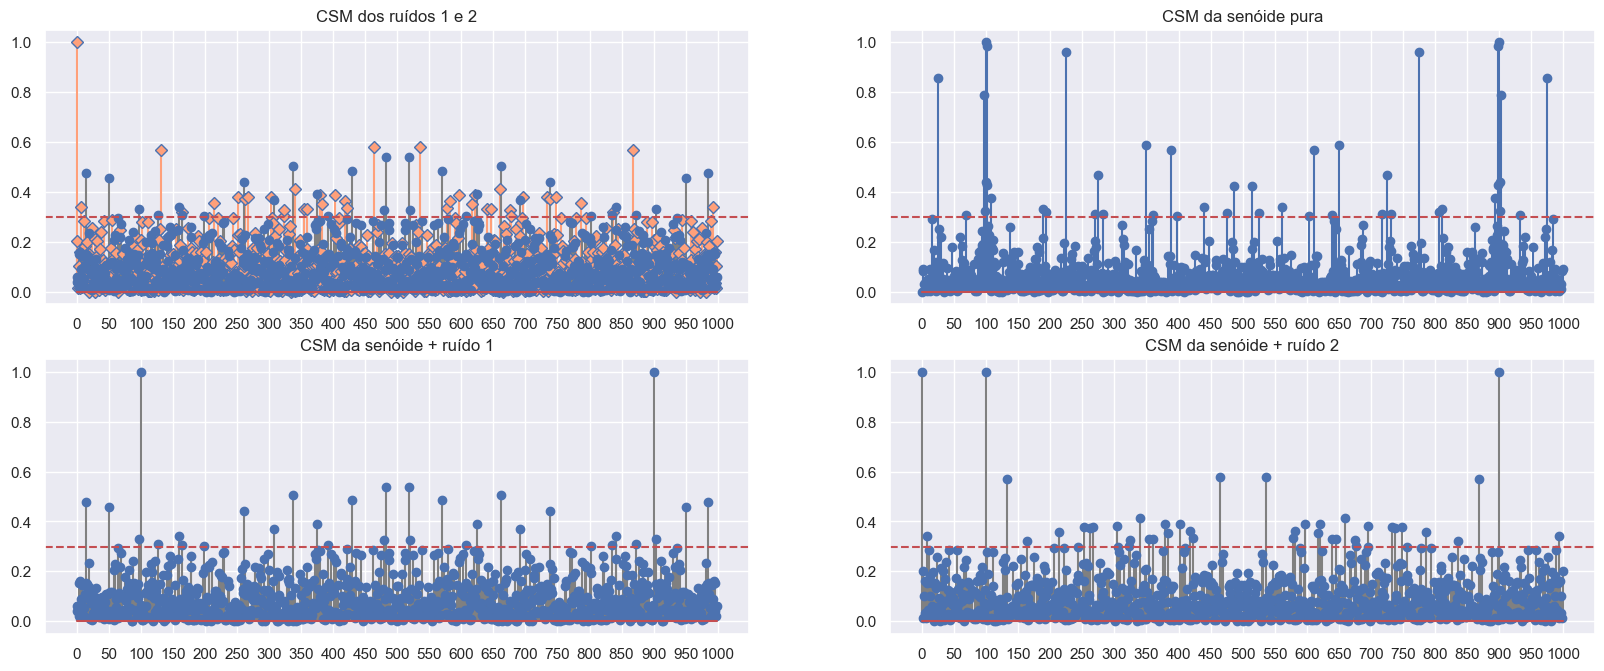

In [2]:
# Calcula senóide base e frequência para encontrar bins:
f0 = 100
fs = 1000
M = 10
tj = fs
N = M*tj

ruido1 = rd.randn(N)
ruido2 = 5*rd.randn(N)+10
sinal = geraSenoide(amplitude=5, N=N, f0 = f0, fs=fs)
[F, _, _] = getFreq(sinal = sinal, fs=fs)
bin_f0 = np.where(F==f0)[0][0]
limiar = vcCSM(M=M, alpha=0.05)

# Calcula CSM:
[_,o1] = ordCSM(sinal=ruido1, tamanhoJanela=tj, M=M)
[_,o2] =ordCSM(sinal=ruido2, tamanhoJanela=tj, M=M)
[_,o3] =ordCSM(sinal=sinal, tamanhoJanela=tj, M=M)
[_,o4] =ordCSM(sinal=sinal+ruido1, tamanhoJanela=tj, M=M)
[_,o5] =ordCSM(sinal=sinal+ruido2, tamanhoJanela=tj, M=M)

plt.subplot(221);
markerline, stemlines, baseline  = plt.stem(o2,linefmt='lightsalmon', markerfmt='D');
markerline.set_markerfacecolor('lightsalmon');
plt.stem(o1,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o2)+len(o2)/20,len(o2)/20));
plt.title('CSM dos ruídos 1 e 2');

plt.subplot(222);
plt.stem(o3);
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o3)+len(o3)/20,len(o3)/20));
plt.title('CSM da senóide pura');

plt.subplot(223);
plt.stem(o4,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o4)+len(o4)/20,len(o5)/20));
plt.title('CSM da senóide + ruído 1');

plt.subplot(224);
plt.stem(o5,linefmt='grey');
plt.axhline(limiar, 0,1,c='r',linestyle='--');
plt.xticks(np.arange(0,len(o5)+len(o5)/20,len(o5)/20));
plt.title('CSM da senóide + ruído 2');

tamanhoSinal = len(o3)
bin_f0 = round(f0*tamanhoSinal/fs)
print('(Detecções no ruído 1) FP:',np.sum(np.where(o1>limiar))/N)
print('(Detecções no ruído 2) FP:',np.sum(np.where(o2>limiar))/N)
print('Detectou a senóide pura?', np.where(o3[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 1?', np.where(o4[bin_f0]>limiar,'Sim.','Não.'))
print('Detectou a senóide + ruído 2?', np.where(o5[bin_f0]>limiar,'Sim.','Não.'))